In [14]:
import torch
import torch.nn as nn
import numpy as np
import joblib

# Define your neural network architecture again for completeness
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        return self.output_layer(x)

# Function to load the models, weights, biases, and potentially 'h' values
def load_model_parameters(model_paths):
    models = []
    all_weights = []
    all_biases = []
    h_values = []  # This would be populated if you save and want to load 'h' values

    for path in model_paths:
        loaded_data = torch.load(path)
        model = NeuralNet(input_size=4, output_size=1)
        model.load_state_dict(loaded_data['state_dict'])
        model.eval()

        weights = [w for w in loaded_data['weights'] if len(w.shape) == 2]  # Assuming weights are 2D
        biases = [w for w in loaded_data['weights'] if len(w.shape) == 1]  # Assuming biases are 1D

        models.append(model)
        all_weights.append(weights)
        all_biases.append(biases)

        # If 'h' values were saved and you want to load them
        # h_values.append(loaded_data.get('h_values', None))

    return models, all_weights, all_biases, h_values

# Example usage
model_paths = [f'/Users/ansonkong/Downloads/model_quantile_{i}.pth' for i in range(7)]  # Adjust path as needed
models, weights, biases, h_values = load_model_parameters(model_paths)

# Print out some of the loaded data to verify
print("Loaded model weights from first model:", weights[0])
print("Loaded model biases from first model:", biases[0])
# If h_values were loaded
# print("Loaded 'h' values from first model:", h_values[0])



Loaded model weights from first model: [array([[ 8.06731582e-02,  6.35355473e-01,  7.57941294e+00,
         3.23161960e+00],
       [-3.80755067e+00, -2.27563405e+00, -1.56587505e+01,
         2.82738042e+00],
       [ 5.02335596e+00,  4.10267687e+00, -1.09967308e+01,
        -1.64677258e+01],
       [-3.23911595e+00, -5.39718676e+00,  1.06935072e+00,
        -1.23488235e+01],
       [ 3.25032210e+00, -4.89470863e+00,  1.54197848e+00,
        -1.27691679e+01],
       [ 5.33085728e+00,  3.86612582e+00, -1.13746099e+01,
        -1.55195389e+01],
       [-3.24162316e+00, -5.99701452e+00,  3.99829745e-01,
        -1.27644329e+01],
       [-2.55233908e+00,  5.73997641e+00, -1.35501661e+01,
         2.45046639e+00],
       [-1.13944900e+00, -1.78562617e+00,  5.69183588e+00,
         2.63413405e+00],
       [ 3.83465815e+00, -4.72998428e+00,  1.19240677e+00,
        -1.30929327e+01],
       [ 1.46733135e-01, -2.50668120e+00, -9.79176044e+00,
        -1.53005543e+01],
       [ 1.90876079e+00, 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


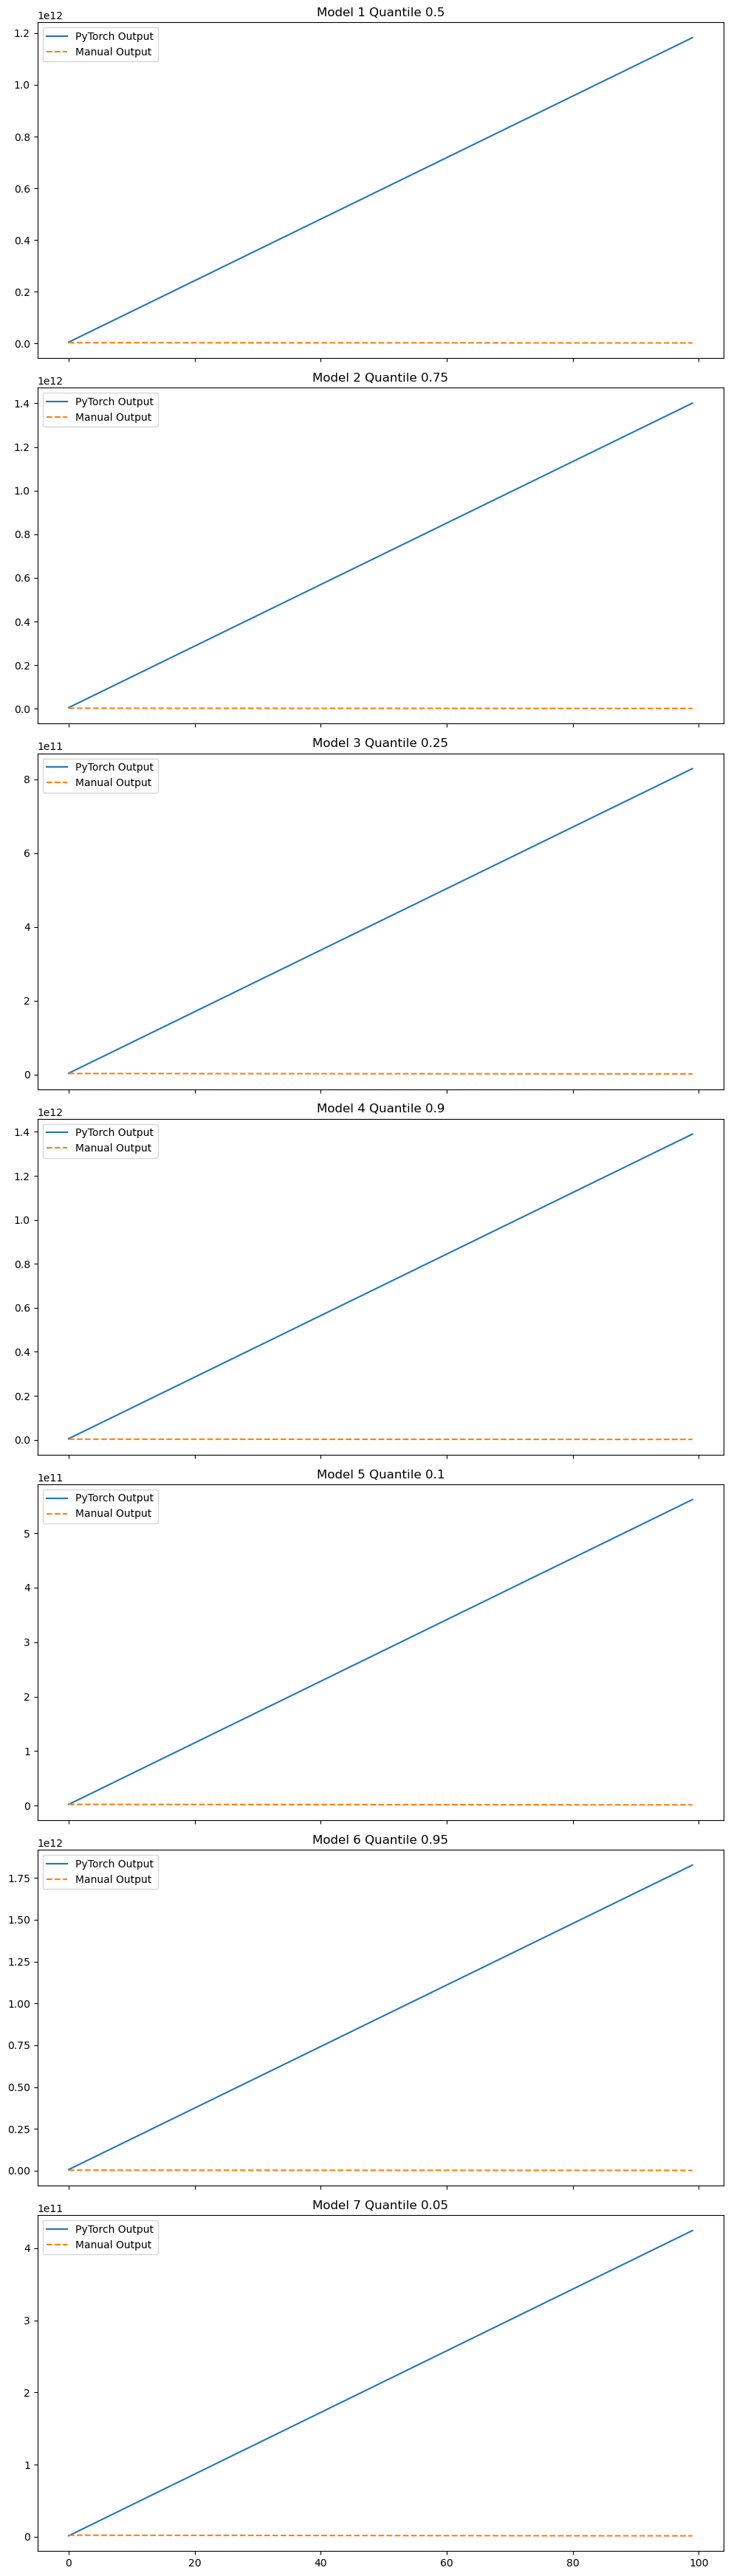

In [17]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import joblib

class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.output_layer(x)
        return x

# Load scaler
scaler = joblib.load('/Users/ansonkong/Downloads/scaler.pkl')

# Initialize models, weights, and biases arrays
models = []
weights = []
biases = []

# Load model data
quantiles = [0.5, 0.75, 0.25, 0.9, 0.1, 0.95, 0.05]
for i, q in enumerate(quantiles):
    model_path = f'/Users/ansonkong/Downloads/model_quantile_{i}.pth'
    model_info = torch.load(model_path)
    model = NeuralNet(input_size=4, output_size=1)
    model.load_state_dict(model_info['state_dict'])
    model.eval()
    
    current_weights = []
    current_biases = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            current_weights.append(param.detach().numpy())
        elif 'bias' in name:
            current_biases.append(param.detach().numpy())
    
    models.append(model)
    weights.append(current_weights)
    biases.append(current_biases)

# Generate test data
input_ranges = [(57.542640, 12822.275981), (20.763935, 12810.664546), (51.748227, 12833.113200), (43.879052, 12630.725896)]
num_samples = 100
test_data = np.array([np.linspace(start, end, num_samples) for start, end in input_ranges]).T

# Plot settings
fig, axs = plt.subplots(len(models), figsize=(10, 5 * len(models)), sharex=True)

for i, model in enumerate(models):
    # PyTorch predictions
    test_tensor = torch.tensor(test_data, dtype=torch.float32)
    pytorch_outputs = model(test_tensor).detach().numpy()

    # Manual predictions
    manual_outputs = np.empty_like(pytorch_outputs)
    for j in range(num_samples):
        x = test_data[j, :]
        x_scaled = (x - scaler.mean_) / scaler.scale_
        for layer_weights, layer_biases in zip(weights[i], biases[i]):
            x_scaled = np.dot(x_scaled, layer_weights.T) + layer_biases
            x_scaled = np.maximum(0, x_scaled)  # ReLU activation
        manual_outputs[j] = x_scaled

    # Plot
    axs[i].plot(pytorch_outputs, label='PyTorch Output')
    axs[i].plot(manual_outputs, label='Manual Output', linestyle='--')
    axs[i].set_title(f'Model {i+1} Quantile {quantiles[i]}')
    axs[i].legend()

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


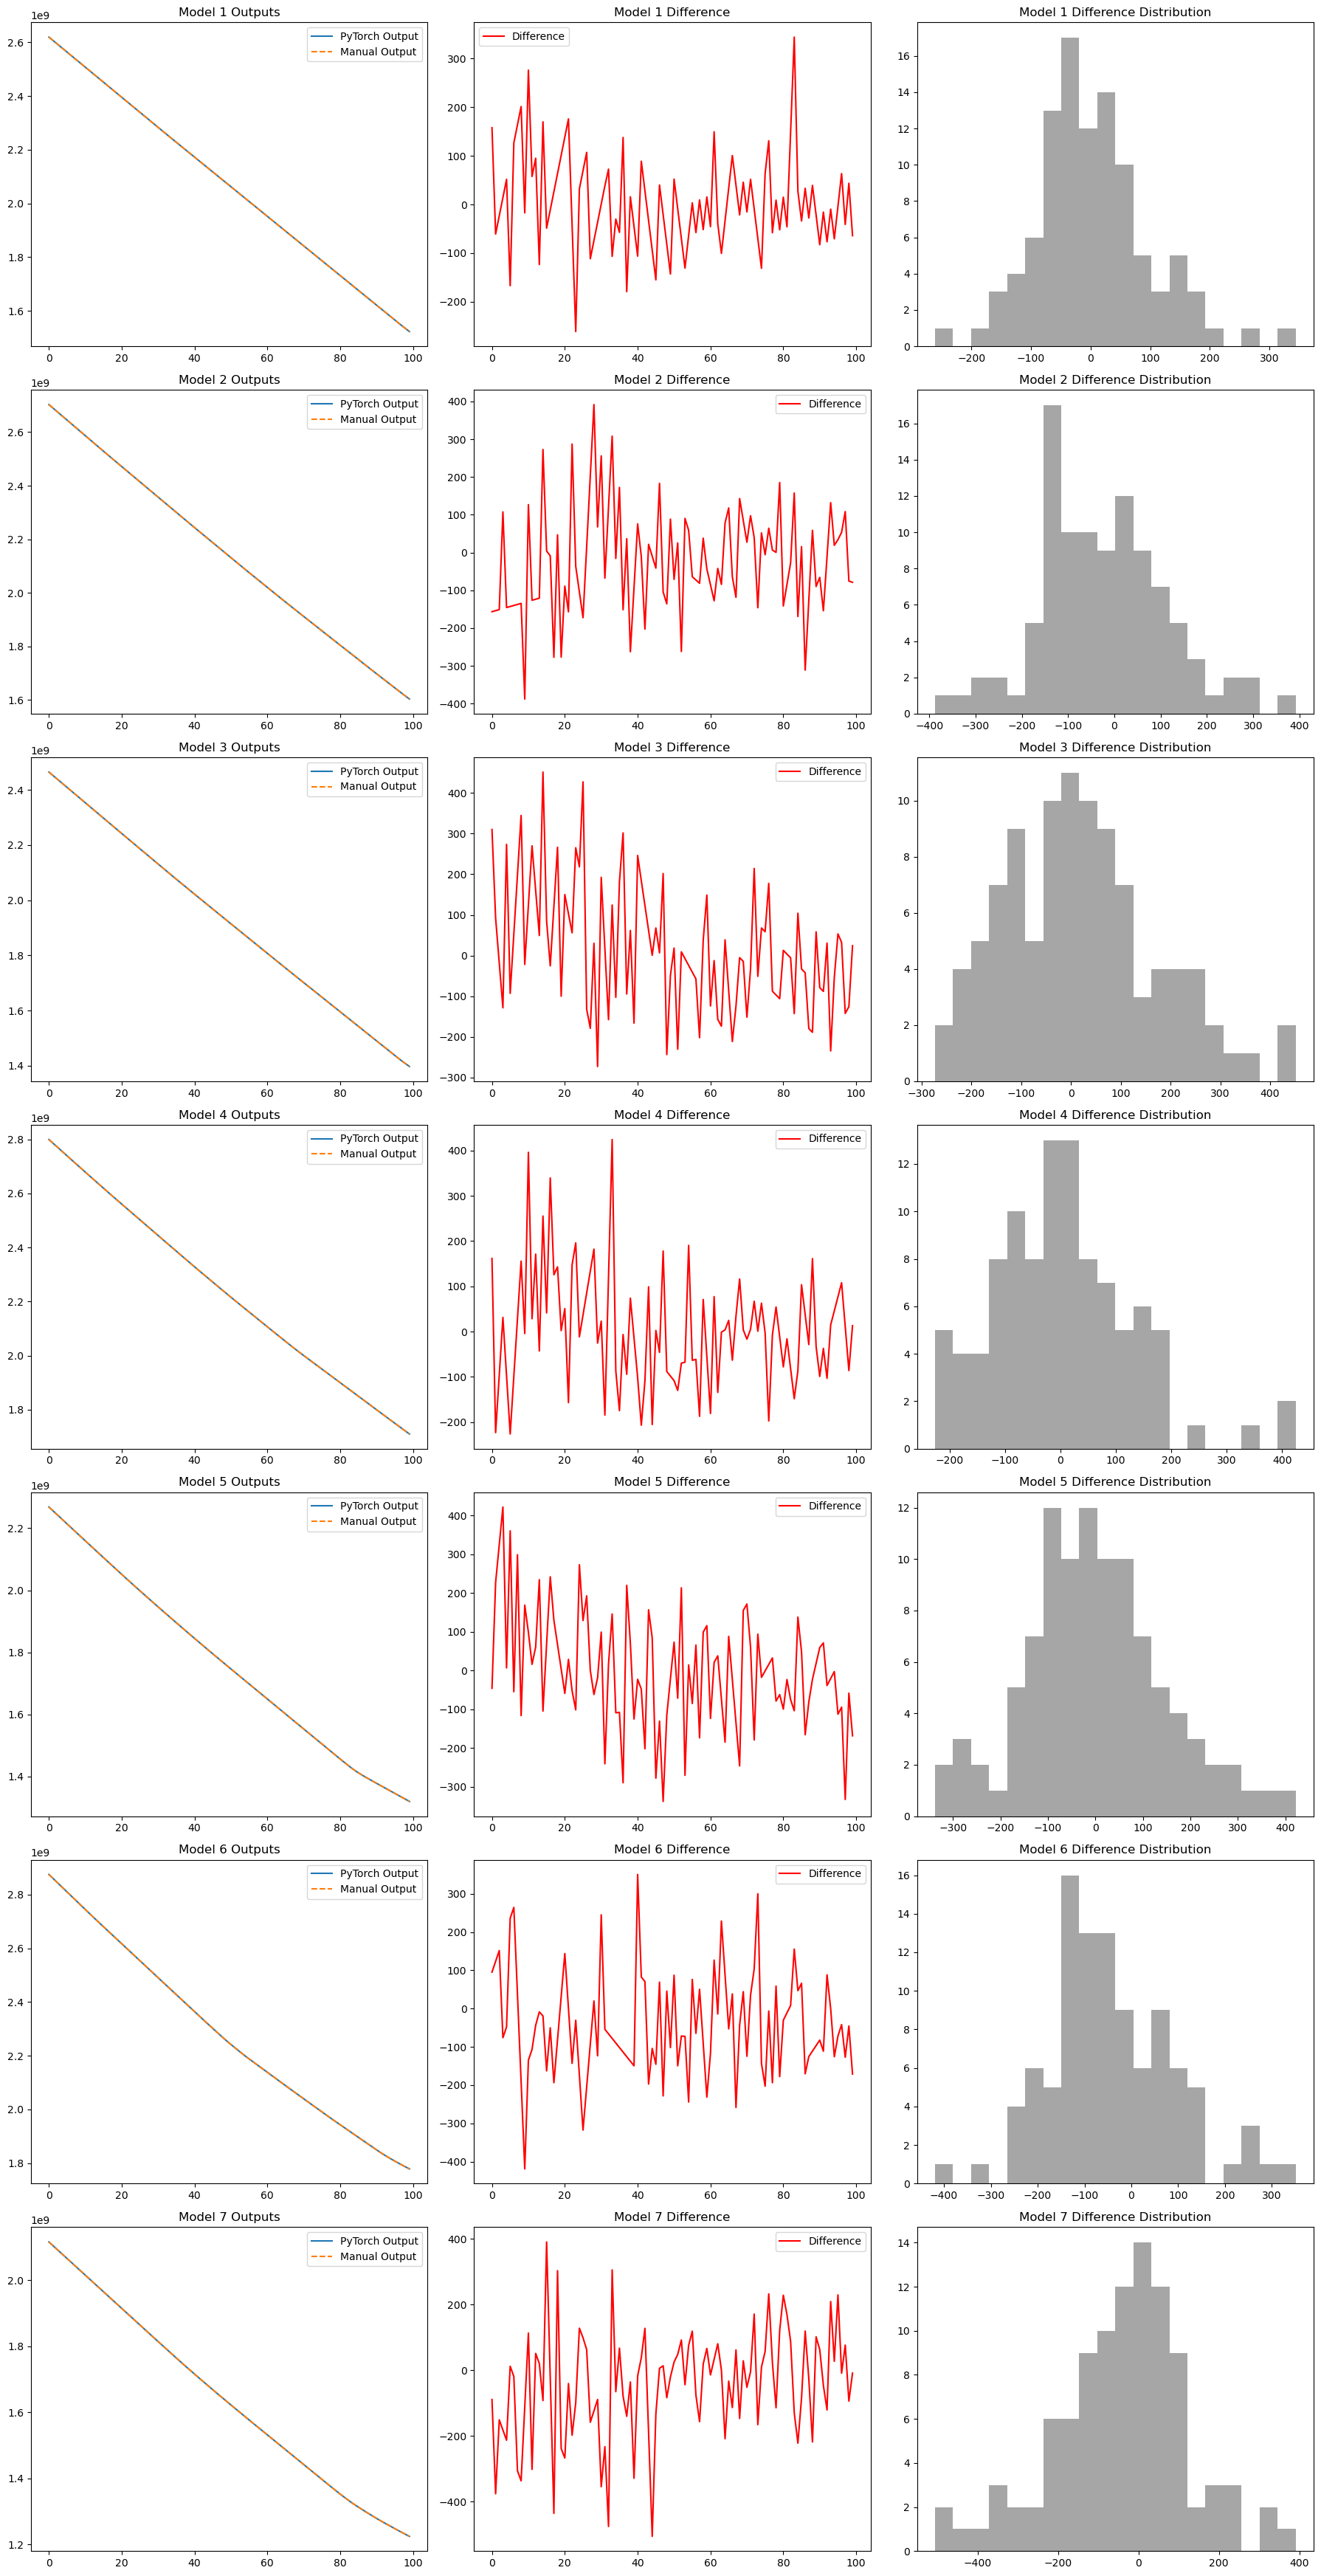

In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import joblib

class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        return self.output_layer(x)

# Load the saved scaler
scaler = joblib.load('/Users/ansonkong/Downloads/scaler.pkl')

# Load models
quantiles = [0.5, 0.75, 0.25, 0.9, 0.1, 0.95, 0.05]
models = []
weights = []
biases = []

for i, q in enumerate(quantiles):
    model = NeuralNet(input_size=4, output_size=1)
    model.load_state_dict(torch.load(f'/Users/ansonkong/Downloads/model_quantile_{i}.pth')['state_dict'])
    model.eval()
    models.append(model)

    # Extract weights and biases
    model_weights = []
    model_biases = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            model_weights.append(param.detach().numpy())
        elif 'bias' in name:
            model_biases.append(param.detach().numpy())
    weights.append(model_weights)
    biases.append(model_biases)

# Generate test data
input_ranges = [(57.542640, 12822.275981), (20.763935, 12810.664546), (51.748227, 12833.113200), (43.879052, 12630.725896)]
num_samples = 100
test_data = np.array([np.linspace(start, end, num_samples) for start, end in input_ranges]).T
scaled_data = scaler.transform(test_data)

# Visual comparison
fig, axs = plt.subplots(len(models), 3, figsize=(18, 5 * len(models)))

for i, model in enumerate(models):
    # PyTorch predictions
    test_tensor = torch.tensor(scaled_data, dtype=torch.float32)
    pytorch_outputs = model(test_tensor).detach().numpy().flatten()

    # Manual forward pass
    x = scaled_data
    for layer_weights, layer_biases in zip(weights[i], biases[i]):
        x = np.dot(x, layer_weights.T) + layer_biases
        x = np.maximum(0, x)  # ReLU activation
    manual_outputs = x.flatten()

    # Plotting
    axs[i, 0].plot(pytorch_outputs, label='PyTorch Output')
    axs[i, 0].plot(manual_outputs, label='Manual Output', linestyle='--')
    axs[i, 0].set_title(f'Model {i+1} Outputs')
    axs[i, 0].legend()

    # Plot differences
    difference = pytorch_outputs - manual_outputs
    axs[i, 1].plot(difference, label='Difference', color='red')
    axs[i, 1].set_title(f'Model {i+1} Difference')
    axs[i, 1].legend()

    # Histogram of differences
    axs[i, 2].hist(difference, bins=20, alpha=0.7, color='gray')
    axs[i, 2].set_title(f'Model {i+1} Difference Distribution')

plt.tight_layout()
plt.show()


In [12]:
import torch
import torch.nn as nn
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import joblib

class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.output_layer(x)
        return x

def setup_optimization(input_ranges, scaler_means, scaler_scales):
    models = []
    weights = []
    biases = []
    scaler = joblib.load('/Users/ansonkong/Downloads/scaler.pkl')

    quantiles = [0.5, 0.75, 0.25, 0.9, 0.1, 0.95, 0.05]
    for idx, q in enumerate(quantiles):
        model_path = f'/Users/ansonkong/Downloads/model_quantile_{idx}.pth'
        model_info = torch.load(model_path)
        model = NeuralNet(input_size=4, output_size=1)
        model.load_state_dict(model_info['state_dict'])
        model.eval()
        current_weights = [param.detach().numpy() for name, param in model.named_parameters() if 'weight' in name]
        current_biases = [param.detach().numpy() for name, param in model.named_parameters() if 'bias' in name]
        models.append(model)
        weights.append(current_weights)
        biases.append(current_biases)

    m = gp.Model("nn_optimization")
    num_inputs = len(input_ranges)
    inputs = m.addVars(num_inputs, lb=[b[0] for b in input_ranges], ub=[b[1] for b in input_ranges], vtype=GRB.CONTINUOUS, name="inputs")

    # Handling scaled inputs manually
    scaled_inputs = [(inputs[i] - scaler_means[i]) / scaler_scales[i] for i in range(num_inputs)]

    # Output variable initialization
    all_outputs = []
    for model_idx, model in enumerate(models):
        layer_input = scaled_inputs
        for layer_idx in range(len(weights[model_idx])):
            layer_output = []
            for neuron_idx in range(len(weights[model_idx][layer_idx])):
                lin_expr = gp.quicksum(weights[model_idx][layer_idx][neuron_idx][k] * layer_input[k] for k in range(len(layer_input))) + biases[model_idx][layer_idx][neuron_idx]
                neuron_output = m.addVar(lb=0, name=f"neuron_{model_idx}_{layer_idx}_{neuron_idx}")
                m.addConstr(neuron_output >= lin_expr, name=f"lin_m{model_idx}_l{layer_idx}_n{neuron_idx}")
                m.addConstr(neuron_output >= 0, name=f"relu_m{model_idx}_l{layer_idx}_n{neuron_idx}")
                layer_output.append(neuron_output)
            layer_input = layer_output
        all_outputs.append(layer_input)

    # Defining the objective function
    final_outputs = [output[0] for output in all_outputs]  # assuming each model has one output neuron in the last layer
    objective_expr = calculate_objective(inputs, final_outputs)
    m.setObjective(objective_expr, GRB.MAXIMIZE)

    m.optimize()

    if m.status == GRB.OPTIMAL:
        optimized_values = {v.VarName: v.X for v in m.getVars() if 'inputs' in v.VarName}
        optimized_values_unscaled = [(optimized_values[f'inputs[{i}]'] * scaler_scales[i] + scaler_means[i]) for i in range(num_inputs)]
        print("Optimized Input Values (Original Scale):", optimized_values_unscaled)
    else:
        print("No optimal solution found.")

def calculate_objective(inputs, outputs):
    return (-4 * inputs[0] - 5 * inputs[1] - 5 * inputs[2] - 1 * inputs[3] +
            0.1 * outputs[0] + 0.15 * outputs[1] + 0.4 * outputs[2] +
            0.2 * outputs[3] + 0.05 * outputs[4] + 0.1 * outputs[5] -
            0.1 * outputs[6])
# Assumes you know the mean and scale of each input feature from your scaler
scaler = joblib.load('/Users/ansonkong/Downloads/scaler.pkl')
scaler_means = [scaler.mean_[i] for i in range(4)]
scaler_scales = [scaler.scale_[i] for i in range(4)]
input_ranges = [
    (57.542640, 12822.275981),
    (20.763935, 12810.664546),
    (51.748227, 12833.113200),
    (43.879052, 12630.725896)]
setup_optimization(input_ranges, scaler_means, scaler_scales)



Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3150 rows, 1579 columns and 78638 nonzeros
Model fingerprint: 0x4032f5ff
Coefficient statistics:
  Matrix range     [7e-08, 3e+01]
  Objective range  [5e-02, 5e+00]
  Bounds range     [2e+01, 1e+04]
  RHS range        [1e-05, 2e+02]
Presolve removed 63 rows and 31 columns
Presolve time: 0.00s

Solved in 0 iterations and 0.00 seconds (0.00 work units)
Infeasible or unbounded model
No optimal solution found.
